# Initial EDA

This notebook collects initial insights about the chosen dataset, namely columns investigation, missing values inspection.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv(os.path.join('..', 'data', 'raw', 'ubaar-competition', 'train.csv'), encoding="utf-8", index_col="ID")

In [3]:
data.head()

,date,sourceLatitude,sourceLongitude,SourceState,destinationLatitude,destinationLongitude,destinationState,distanceKM,taxiDurationMin,vehicleType,vehicleOption,weight,price
ID,,,,,,,,,,,,,
88142929797,960218,36.666045,48.489706,زنجان,29.600574,52.537114,فارس,1092.0,751.0,treili,kafi,20.00,15300000
30842979862,960511,32.323951,50.855412,چهارمحال و بختیاری,34.644923,50.876092,قم,414.0,264.0,khavar,mosaghaf_felezi,2.50,1800000
54262798716,960602,32.575448,51.581011,اصفهان,31.819508,49.865235,خوزستان,310.0,292.0,joft,kompressi,14.97,3742000
64071173752,960319,35.029685,48.085763,کردستان,35.703801,51.398824,تهران,391.0,271.0,khavar,mosaghaf_felezi,2.50,1300000
68088966447,960609,31.586965,54.449607,یزد,36.730367,53.965480,گلستان,756.0,573.0,joft,bari,15.00,8870000


In [4]:
data.shape

(50000, 13)

We have 50k observations with 13 columns. Columns names are descriptive. 

# Checking missing values

In [5]:
data.isna().sum()

date                    0
sourceLatitude          0
sourceLongitude         0
SourceState             0
destinationLatitude     0
destinationLongitude    0
destinationState        0
distanceKM              3
taxiDurationMin         3
vehicleType             0
vehicleOption           0
weight                  0
price                   0
dtype: int64

# `date` column

In [6]:
import jdatetime

def convert_data_to_gregorian(date):
    date = str(date)
    
    return jdatetime.date(1300+int(date[:2]), int(date[2:4]), int(date[4:6])).togregorian().strftime('%Y-%m-%d')
    
data['date'] = data['date'].apply(convert_data_to_gregorian).astype("datetime64")

([], [])

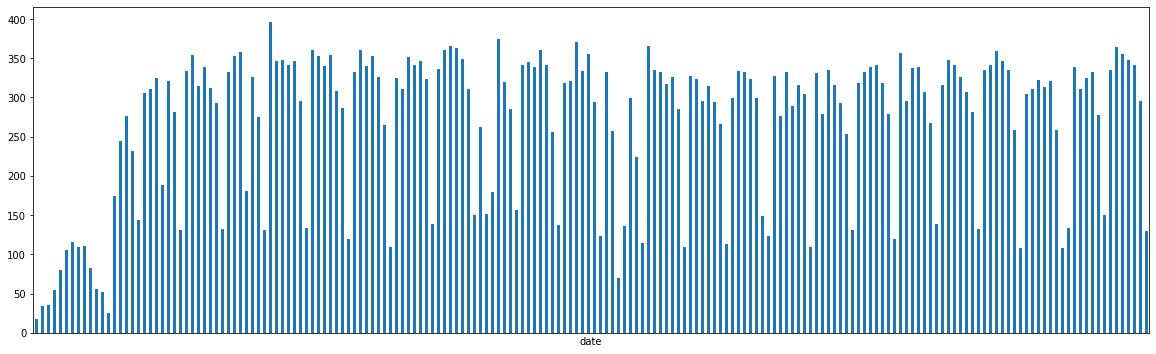

In [7]:
fig, ax = plt.subplots(figsize = (20,6))
data['date'].groupby(data["date"]).count().plot(kind="bar")
plt.xticks([])

We can see that there is one or maybe one and a half day where there is smaller number of transports. It's possible to encode the date as the day of the week.

# Latitudes

Latitudes are important. They may be correlated with distances but Iran is mountainous and it may not be that simple. 
Also, the economical status of a state and local dependencies may influence the price.

Therefore it would be beneficial to encode latitudes in some meaningful feature.

Possible encodings are implemented in `feature_extraction/coords_features.py`. 

Moreover, coordinates clusterization is performed in a few ways there.

In [8]:
# `sourceLatitude`, `sourceLongitude`, 'destinationLatitude', 'destinationLongitude'

# SourceState column

In [9]:
len(np.unique(data["SourceState"]))

31

<AxesSubplot:xlabel='count', ylabel='destinationState'>

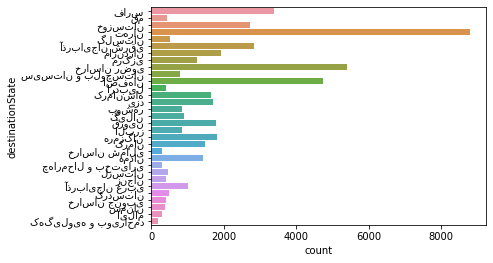

In [10]:
sns.countplot(data=data, y='destinationState')

# destinationState column

In [11]:
len(np.unique(data["destinationState"]))

31

<AxesSubplot:xlabel='count', ylabel='destinationState'>

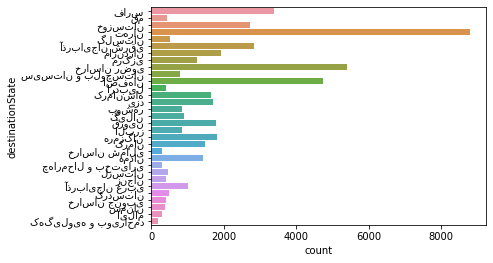

In [12]:
sns.countplot(data=data, y='destinationState')

# `distanceKM` and `taxiDurationMin`

Both variables have missing data. Let's check it

In [13]:
data[data['distanceKM'].isna()]

,date,sourceLatitude,sourceLongitude,SourceState,destinationLatitude,destinationLongitude,destinationState,distanceKM,taxiDurationMin,vehicleType,vehicleOption,weight,price
ID,,,,,,,,,,,,,
79421499936,2017-04-17,37.280551,49.586155,گیلان,38.080153,46.296114,آذربایجان شرقی,NaN,NaN,khavar,hichkodam,4.50,4300000
67133186102,2017-06-18,37.476449,49.369495,گیلان,31.328880,48.673074,خوزستان,NaN,NaN,treili,kafi,23.26,18500000
17183110848,2017-07-06,35.698837,51.385724,تهران,38.413859,48.873461,گیلان,NaN,NaN,tak,bari,3.00,4600000


Missing features contain the same rows. It does not look like it is related to any other variable in the dataset. These features may be important so we have 3 possibilities:
- Remove the rows because there are only 3 of them
- Replace nans with a mean value 
- Interpolate Nans with the values based on source-destination latitudes/longitudes.

In [14]:
data['distanceKM'].fillna(data['distanceKM'].median(), inplace=True)
data['taxiDurationMin'].fillna(data['taxiDurationMin'].median(), inplace=True)

Then it may be a good idea to plot these variables together beacuse they may be correlated

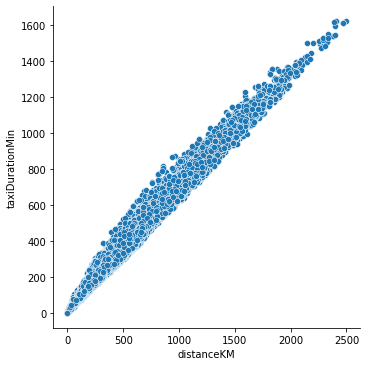

In [15]:
sns.relplot(x="distanceKM", y="taxiDurationMin", data=data);

<AxesSubplot:xlabel='distanceKM', ylabel='Count'>

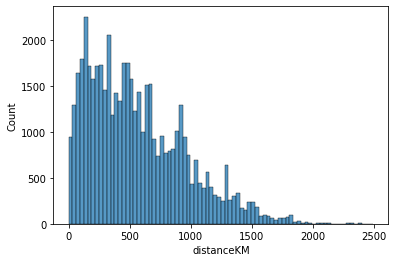

In [16]:
sns.histplot(data=data, x='distanceKM')

Not very useful distribution

# `vehicleType` and `vehicleOption` columns

Text(0.5, 0, 'Count of vehicle type')

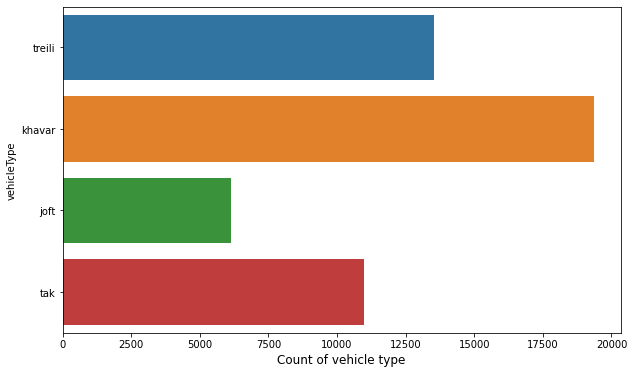

In [17]:
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.countplot(ax=ax, data=data, y='vehicleType')
ax.set_xlabel("Count of vehicle type", size=12)

<AxesSubplot:xlabel='count', ylabel='vehicleOption'>

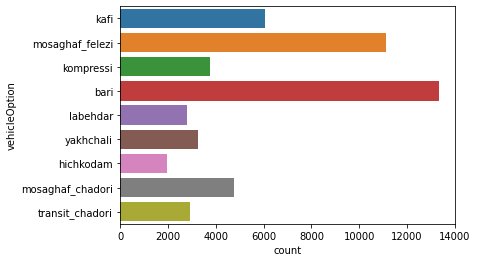

In [18]:
sns.countplot(data=data, y='vehicleOption')

None of the values seem to be neglectable nor dominant.

Maybe vehicle type can be correlated with weight? 

<AxesSubplot:xlabel='vehicleType', ylabel='weight'>

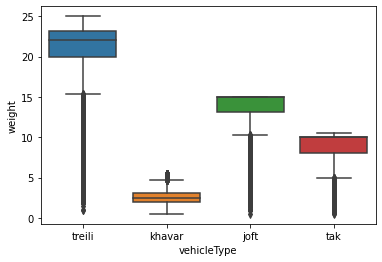

In [19]:
sns.boxplot(data=data, x='vehicleType', y='weight')

<AxesSubplot:xlabel='vehicleOption', ylabel='weight'>

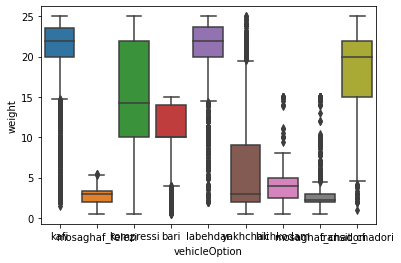

In [20]:
sns.boxplot(data=data, x='vehicleOption', y='weight')

Both variables are correlated with weight. Can we see anything similar with trip length?

<AxesSubplot:xlabel='vehicleOption', ylabel='distanceKM'>

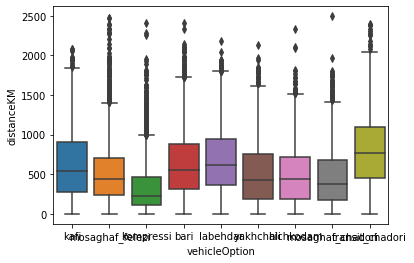

In [21]:
sns.boxplot(data=data, x='vehicleOption', y='distanceKM')

<AxesSubplot:xlabel='vehicleType', ylabel='distanceKM'>

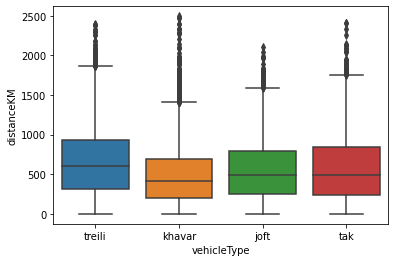

In [22]:
sns.boxplot(data=data, x='vehicleType', y='distanceKM')

Not really, all vehicles can ride long and short distances but not all can transport heavy loads.

Maybe something interesting between `price` and `vehicleType`?

<AxesSubplot:xlabel='vehicleType', ylabel='price'>

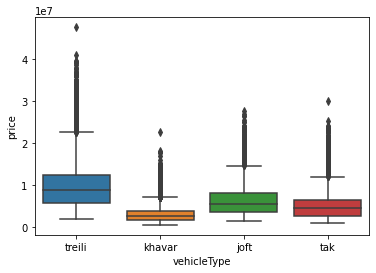

In [23]:
sns.boxplot(data=data, x='vehicleType', y='price')

We can see that there a a lot of small weight transports (the most of transports are small khavar transports).

However, the most cumulative price is from big trelli transports with most weight

<AxesSubplot:xlabel='vehicleType', ylabel='sum of all transports price'>

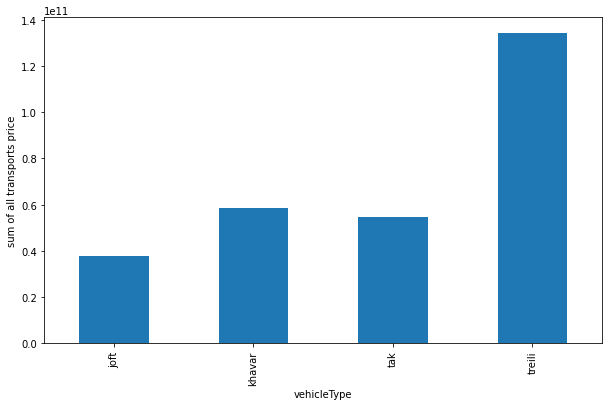

In [24]:
plt.figure(figsize=(10,6))
data.groupby('vehicleType')['price'].sum().plot(kind='bar',ylabel='sum of all transports price')

# Weight 

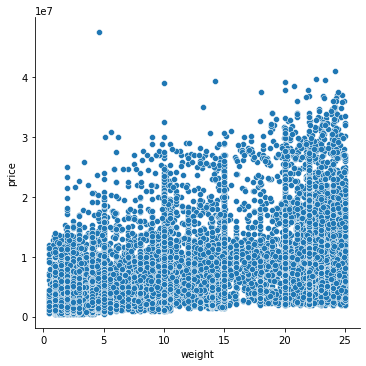

In [25]:
sns.relplot(x="weight", y="price", data=data);

Weight and price variables are not really correlated. Let's take a look at them separately

<AxesSubplot:xlabel='weight', ylabel='Count'>

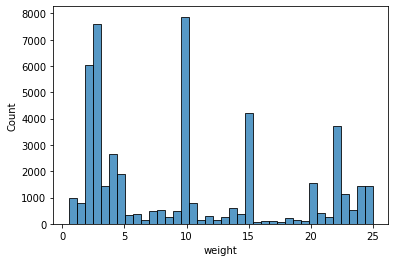

In [26]:
sns.histplot(data=data, x='weight')

Weights are interesting because the distribution has four peaks and is not smooth. That's great especially considering the distribution of previous features

<AxesSubplot:xlabel='weight_dist', ylabel='Count'>

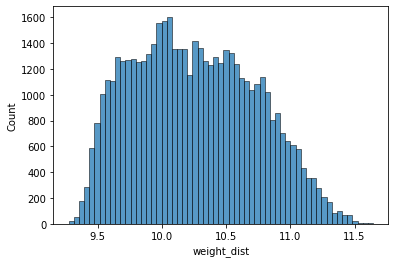

In [27]:
data['weight_dist'] = np.log(1.0 + (10.0 + data['weight']) * (1000.0 + data['distanceKM']))
sns.histplot(data=data, x='weight_dist')

A very nice new feature, may be useful for modeling.

# `price`

<AxesSubplot:xlabel='price', ylabel='Count'>

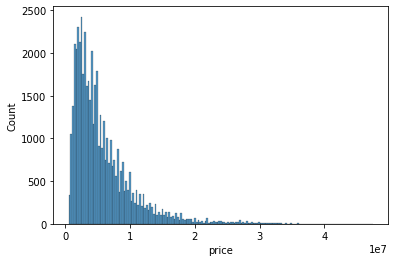

In [28]:
sns.histplot(data=data, x='price')

`Price` is fairly typical with not as many high values as low values.

However, because we are going to predict this variable we must take into consideration the fact that extreme values will be hard to model. Let's check how many transports cost more than 30000000 rials. 

In [29]:
n = 20000000
print(f"Transactions more expensive than {n} rials: {len(data[data['price'] > n])* 100 / len(data)}%")

Transactions more expensive than 20000000 rials: 1.866%


Let's visualize it on boxplot to see quantiles:

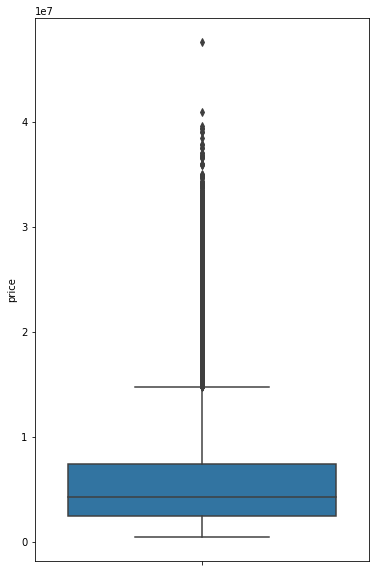

In [30]:
plt.figure(figsize=(6,10))
sns.boxplot(data=data, y='price') #.set_yscale('log')
plt.show()

Half of the prices are in the range 350k-750k, and the q90 is around 1.6M. This will definitely impact model quality.

Let's try to apply some transformation to achieve distribution easier to model:

<AxesSubplot:xlabel='price_log', ylabel='Count'>

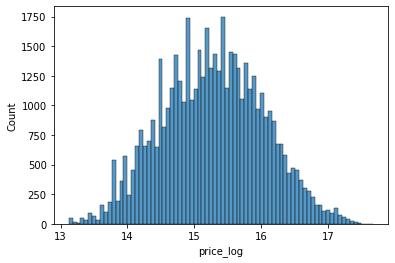

In [31]:
import numpy as np
data['price_log'] = np.log(data['price'])
sns.histplot(data=data, x='price_log')

Data is clear and clean, should allow modeling, and features are easy to understand.